In [1]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Import the necessary libraries
import numpy as np
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as col
import scipy.ndimage as ndimage
from scipy.ndimage.filters import minimum_filter, maximum_filter
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec

import cartopy
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy import util as cu

import metpy
import metpy.calc as calc

Loaded dataset from UAlbany thredds server
Subsetted data
Set up cartopy projection & geography
Filled contours for 850-hPa temperature
Filled contours for PWAT
Filled contours for 250-hPa wind
Filled contours for 500-hPa vorticity
Contours complete for MSLP
Contours complete for 500-hPa heights
Barbs complete for 850-hPa wind


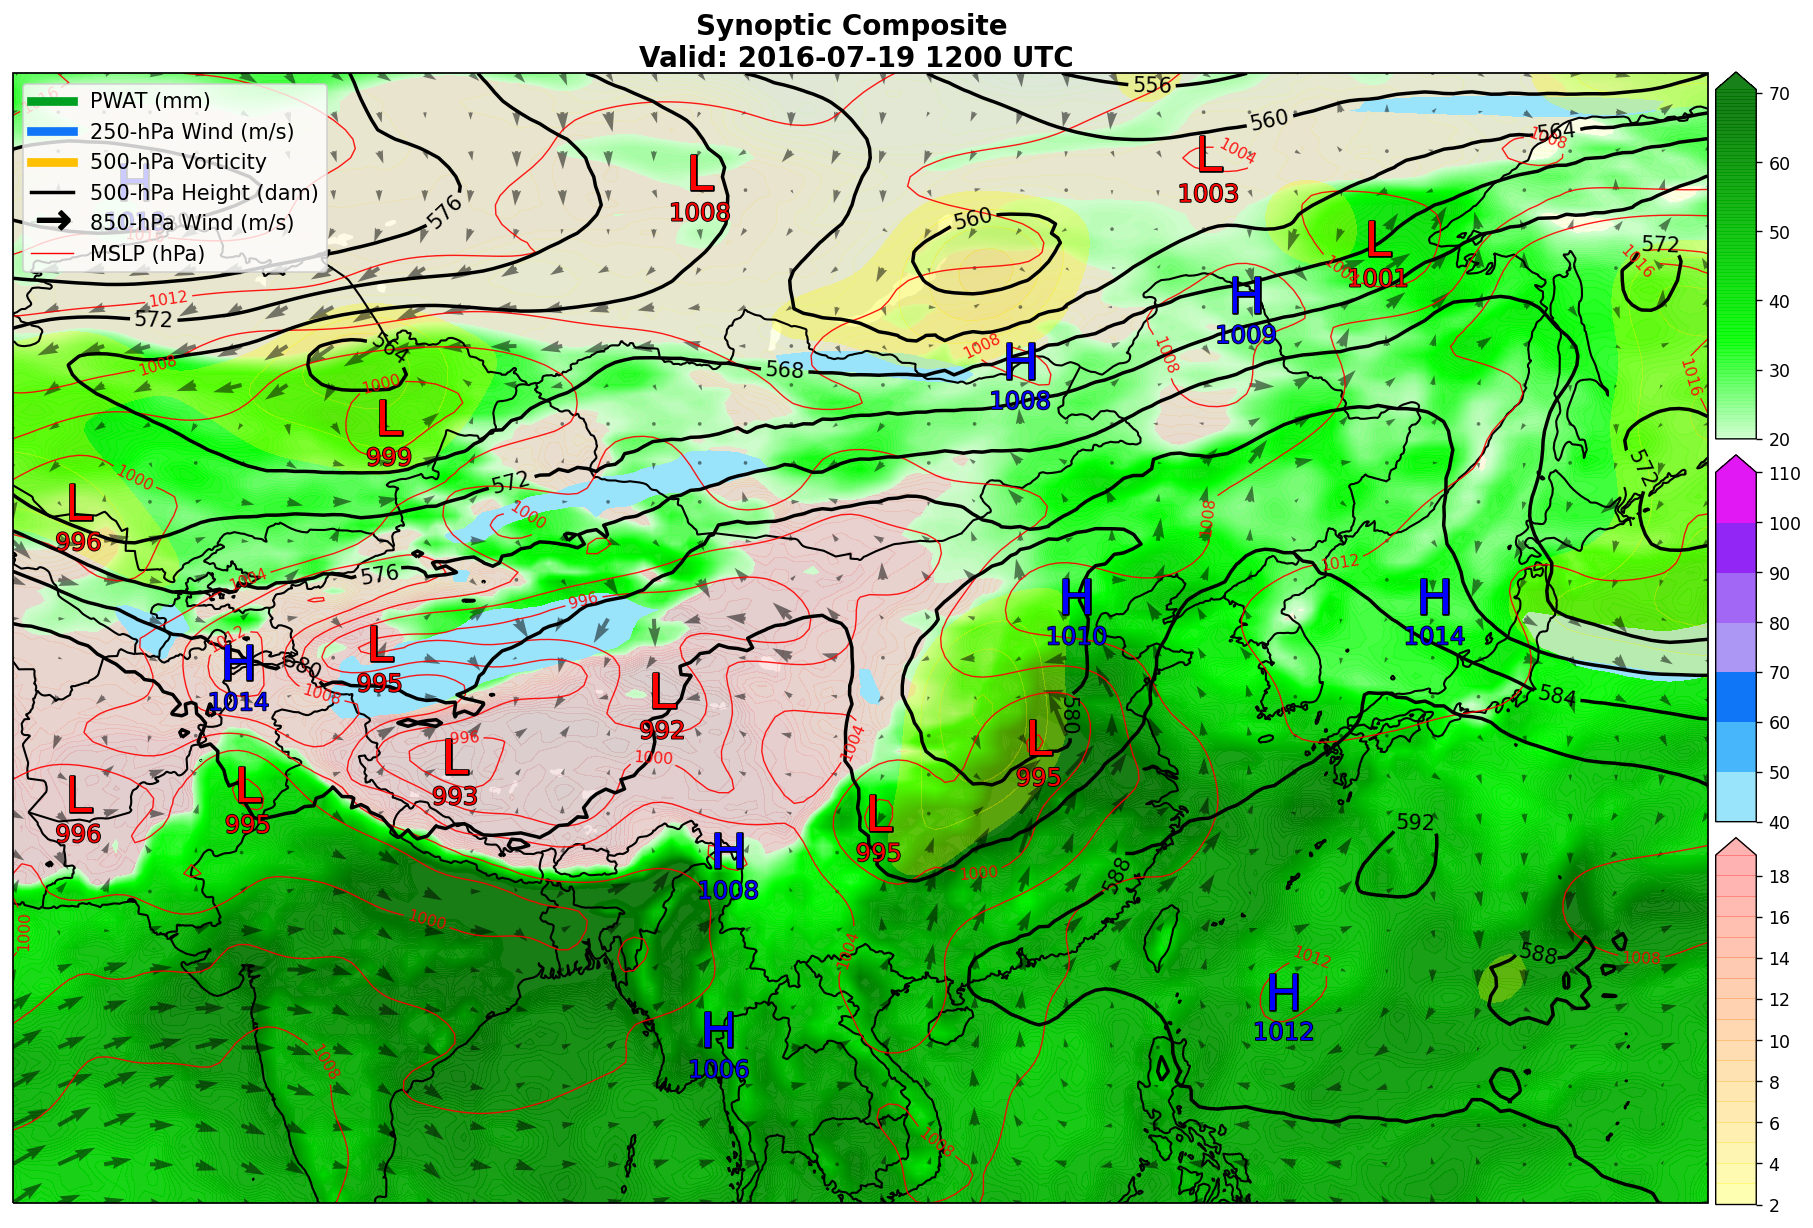

Done!


In [7]:
"""
CFSR Synoptic Composite Plotting Script
Written by Tomer Burg
Last revised 1/24/2019
Python 3.6
This script retrieves CFSR data from UAlbany's THREDDS server, and plots
a composite of various synoptically-relevant variables using MetPy and Cartopy with
a standard mercator projection. This script plots data for a single time step, although
it is possible to edit this into a loop over multiple time steps.
"""



#========================================================================================================
# Specify settings below
#========================================================================================================

#Enter the date and hour to visualize data for, in YYYYMMDDHH format (e.g., 3/13/1993 18 UTC = 1993031318)
plot_date = "2016071912"

#Choose the lat/lon range over which to get data for and plot the map.
map_subset = 1 #if zero, then the following 4 variables will be ignored and a global plot will be made.
lat_south = 20.0
lat_north = 60.0
lon_west = 70.
lon_east = 140.

#========================================================================================================
# Step 1. Load the variables from UAlbany's opendap server
#========================================================================================================

#To make parsing the date easier, convert it into a datetime object and get it into various formats
date_obj = dt.datetime.strptime(plot_date,'%Y%m%d%H')
yyyy = date_obj.year
mm = date_obj.month
dd = date_obj.day
yyyymmdd = dt.datetime.strftime(date_obj,'%Y%m%d')

#For loading multiple files in
files = []

#Loop through each variable specified
variables = ['u','v','g','t','pmsl','pwat']
for var in variables:
    
    #Append file into list of files to open
    filepath = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CFSR/%s/%s.%s.0p5.anl.nc"%(yyyy,var,yyyy)
    files.append(filepath)
    
#Load in the variable(s) as an xarray Dataset and assign them into "data"
data = xr.open_mfdataset(files, combine='by_coords')

print("Loaded dataset from UAlbany thredds server")

#========================================================================================================
# Step 2. Subset the data by pressure level, time and geographic region
#========================================================================================================

#Subset by the time
data = data.sel(time=date_obj)

#Subset data by latitude and longitude, if requested
if map_subset == 1:
    data = data.sel(lat=slice(lat_south-10,lat_north+10),lon=slice(lon_west-10,lon_east+10))
    
#Get lat and lon arrays for this dataset:
lat = data.lat.values
lon = data.lon.values

print("Subsetted data")

#========================================================================================================
# Step 3. Create a Basemap plotting figure and add geography
#========================================================================================================

#Create a Plate Carree projection object
proj_ccrs = ccrs.Miller(central_longitude=0.0)

#Create figure and axes for main plot and colorbars
fig = plt.figure(figsize=(18,12),dpi=125)
gs = gridspec.GridSpec(12, 36, figure=fig) #[ytop:ybot, xleft:xright]
ax = plt.subplot(gs[:, :-1],projection=proj_ccrs) #main plot
ax.set_xticklabels([])
ax.set_yticklabels([])
ax2 = plt.subplot(gs[:4, -1]) #top plot
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3 = plt.subplot(gs[4:8, -1]) #bottom plot
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax4 = plt.subplot(gs[8:, -1]) #bottom plot
ax4.set_xticklabels([])
ax4.set_yticklabels([])

#Add political boundaries and coastlines
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidths=1.2)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidths=1.2)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidths=0.5)

#Add land/lake/ocean masking
land_mask = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='face',
                                    facecolor='#e6e6e6')
sea_mask = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                    edgecolor='face',
                                    facecolor='#ffffff')
lake_mask = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                    edgecolor='face',
                                    facecolor='#ffffff')
ax.add_feature(sea_mask,zorder=0)
ax.add_feature(land_mask,zorder=0)
ax.add_feature(lake_mask,zorder=0)

print("Set up cartopy projection & geography")

#========================================================================================================
# Supplementary functions
#========================================================================================================


            
#Spatially smooth a 2D variable
def smooth(prod,sig):
    
    #Check if variable is an xarray dataarray
    try:
        lats = prod.lat.values
        lons = prod.lon.values
        prod = ndimage.gaussian_filter(prod,sigma=sig,order=0)
        prod = xr.DataArray(prod, coords=[lats, lons], dims=['lat', 'lon'])
    except:
        prod = ndimage.gaussian_filter(prod,sigma=sig,order=0)
    
    return prod

#Label MSLP extrema
def extrema(mat,mode='wrap',window=50):
        mn = minimum_filter(mat, size=window, mode=mode)
        mx = maximum_filter(mat, size=window, mode=mode)
        return np.nonzero(mat == mn), np.nonzero(mat == mx)

def mslp_label(mslp,lat,lon):
    
    #Determine an appropriate window given the lat/lon grid resolution
    res = lat[1] - lat[0]
    nwindow = int(9.5 / res)
    mslp = np.ma.masked_invalid(mslp)
    local_min, local_max = extrema(mslp, mode='wrap', window=nwindow)
    
    #Determine axis boundaries
    xmin, xmax, ymin, ymax = ax.get_extent()
    lons2d, lats2d = np.meshgrid(lon, lat)
    transformed = proj_ccrs.transform_points(proj_ccrs, lons2d, lats2d)
    x = transformed[..., 0]
    y = transformed[..., 1]
    
    #Get location of extrema on grid
    xlows = x[local_min]; xhighs = x[local_max]
    ylows = y[local_min]; yhighs = y[local_max]
    lowvals = mslp[local_min]; highvals = mslp[local_max]
    yoffset = 0.022*(ymax-ymin)
    dmin = yoffset
    
    #Plot low pressures
    xyplotted = []
    for x,y,p in zip(xlows, ylows, lowvals):
        if x < xmax-yoffset and x > xmin+yoffset and y < ymax-yoffset and y > ymin+yoffset:
            dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
            if not dist or min(dist) > dmin: #,fontweight='bold'
                a = ax.text(x,y,'L',fontsize=28,
                        ha='center',va='center',color='r',fontweight='normal')
                b = ax.text(x,y-yoffset,repr(int(p)),fontsize=14,
                        ha='center',va='top',color='r',fontweight='normal')
                a.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'),
                       path_effects.SimpleLineShadow(),path_effects.Normal()])
                b.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                       path_effects.SimpleLineShadow(),path_effects.Normal()])
                xyplotted.append((x,y))
                
    #Plot high pressures
    xyplotted = []
    for x,y,p in zip(xhighs, yhighs, highvals):
        if x < xmax-yoffset and x > xmin+yoffset and y < ymax-yoffset and y > ymin+yoffset:
            dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
            if not dist or min(dist) > dmin:
                a = ax.text(x,y,'H',fontsize=28,
                        ha='center',va='center',color='b',fontweight='normal')
                b = ax.text(x,y-yoffset,repr(int(p)),fontsize=14,
                        ha='center',va='top',color='b',fontweight='normal')
                a.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'),
                       path_effects.SimpleLineShadow(),path_effects.Normal()])
                b.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                       path_effects.SimpleLineShadow(),path_effects.Normal()])
                xyplotted.append((x,y))

#========================================================================================================
# Step 4. Fill contours
#========================================================================================================

#--------------------------------------------------------------------------------------------------------
# 850-hPa temperature
#--------------------------------------------------------------------------------------------------------

#Get the data for this variable
temp = data['t'].sel(lev=850)
temp.metpy.convert_units('degC')

#Specify contour settings
clevs = np.arange(-40,40,1)
cmap = plt.cm.jet
extend = "both"

#Contour fill this variable
norm = col.BoundaryNorm(clevs,cmap.N)
cs = ax.contourf(lon,lat,temp,clevs,cmap=cmap,norm=norm,extend=extend,transform=proj_ccrs,alpha=0.1)

print("Filled contours for 850-hPa temperature")

#--------------------------------------------------------------------------------------------------------
# PWAT
#--------------------------------------------------------------------------------------------------------

#Get the data for this variable
pwat = data['pwat']
pwat.metpy.convert_units('mm')

#Specify contour settings
clevs = np.arange(20,71,0.5)

#Define a color gradient for PWAT
pwat_colors = gradient([[(255,255,255),0.0],[(255,255,255),20.0]],
               [[(205,255,205),20.0],[(0,255,0),34.0]],
               [[(0,255,0),34.0],[(0,115,0),67.0]])
cmap = pwat_colors.get_cmap(clevs)
extend = "max"

#Contour fill this variable
norm = col.BoundaryNorm(clevs,cmap.N)
cs = ax.contourf(lon,lat,pwat,clevs,cmap=cmap,norm=norm,extend=extend,transform=proj_ccrs,alpha=0.9)

#Add a color bar
cbar = plt.colorbar(cs,cax=ax2,shrink=0.75,pad=0.01,ticks=[20,30,40,50,60,70])

print("Filled contours for PWAT")

#--------------------------------------------------------------------------------------------------------
# 250-hPa wind
#--------------------------------------------------------------------------------------------------------

#Get the data for this variable
u = data['u'].sel(lev=250)
v = data['v'].sel(lev=250)
wind = calc.wind_speed(u,v)

#Specify contour settings
clevs = [40,50,60,70,80,90,100,110]
cmap = col.ListedColormap(['#99E3FB','#47B6FB','#0F77F7','#AC97F5','#A267F4','#9126F5','#E118F3','#E118F3'])
extend = "max"

#Contour fill this variable
norm = col.BoundaryNorm(clevs,cmap.N)
cs = ax.contourf(lon,lat,wind,clevs,cmap=cmap,norm=norm,extend=extend,transform=proj_ccrs)

#Add a color bar
cbar = plt.colorbar(cs,cax=ax3,shrink=0.75,pad=0.01,ticks=clevs)

print("Filled contours for 250-hPa wind")

#--------------------------------------------------------------------------------------------------------
# 500-hPa smoothed vorticity
#--------------------------------------------------------------------------------------------------------

#Get the data for this variable
u = data['u'].sel(lev=500)
v = data['v'].sel(lev=500)
dx,dy = calc.lat_lon_grid_deltas(lon,lat)
vort = calc.vorticity(u,v,dx,dy)
smooth_vort = smooth(vort, 5.0) * 10**5

#Specify contour settings
clevs = np.arange(2,20,1)
cmap = plt.cm.autumn_r
extend = "max"

#Contour fill this variable
norm = col.BoundaryNorm(clevs,cmap.N)
cs = ax.contourf(lon,lat,smooth_vort,clevs,cmap=cmap,norm=norm,extend=extend,transform=proj_ccrs,alpha=0.3)

#Add a color bar
cbar = plt.colorbar(cs,cax=ax4,shrink=0.75,pad=0.01,ticks=clevs[::2])

print("Filled contours for 500-hPa vorticity")
        
#========================================================================================================
# Step 5. Contours
#========================================================================================================

#--------------------------------------------------------------------------------------------------------
# MSLP
#--------------------------------------------------------------------------------------------------------

#Get the data for this variable
mslp = data['pmsl']
mslp = mslp / 100.0

#Specify contour settings
clevs = np.arange(960,1040+4,4)
style = 'solid' #Plot solid lines
color = 'red' #Plot lines as gray
width = 0.8 #Width of contours 0.25

#Contour this variable
cs = ax.contour(lon,lat,mslp,clevs,colors=color,linewidths=width,linestyles=style,transform=proj_ccrs,alpha=0.9)

#Include value labels
ax.clabel(cs, inline=1, fontsize=9, fmt='%d')

print("Contours complete for MSLP")

#--------------------------------------------------------------------------------------------------------
# Geopotential heights
#--------------------------------------------------------------------------------------------------------

#Get the data for this variable
hght = data['g'].sel(lev=500)
hght = hght / 10.0

#Specify contour settings
clevs = np.arange(480,612,4)
style = 'solid' #Plot solid lines
color = 'black' #Plot lines as gray
width = 2.0 #Width of contours

#Contour this variable
cs = ax.contour(lon,lat,hght,clevs,colors=color,linewidths=width,linestyles=style,transform=proj_ccrs)

#Include value labels
ax.clabel(cs, inline=1, fontsize=12, fmt='%d')

print("Contours complete for 500-hPa heights")


#--------------------------------------------------------------------------------------------------------
# Surface barbs
#--------------------------------------------------------------------------------------------------------

#Get data for wind barbs
u = data['u'].sel(lev=850)
v = data['v'].sel(lev=850)

#Plot wind barbs
quivers = ax.quiver(lon, lat, u.values, v.values, transform=proj_ccrs, regrid_shape=(38,30), scale=820, alpha=0.5)

print("Barbs complete for 850-hPa wind")

#--------------------------------------------------------------------------------------------------------
# Label highs & lows
#--------------------------------------------------------------------------------------------------------

#Label highs and lows
mslp_label(mslp,lat,lon)

#========================================================================================================
# Step 6. Add legend, plot title, then save image and close
#========================================================================================================

#Add custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#00A123', lw=5),
                Line2D([0], [0], color='#0F77F7', lw=5),
                Line2D([0], [0], color='#FFC000', lw=5),
                Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color='k', lw=0.1, marker=r'$\rightarrow$', ms=20),
                Line2D([0], [0], color='r', lw=0.8),
               ]

ax.legend(custom_lines, ['PWAT (mm)', '250-hPa Wind (m/s)', '500-hPa Vorticity', '500-hPa Height (dam)', '850-hPa Wind (m/s)', 'MSLP (hPa)'], loc=2, prop={'size':12})

#Format plot title
title = "Synoptic Composite \nValid: " + dt.datetime.strftime(date_obj,'%Y-%m-%d %H%M UTC')
st = plt.suptitle(title,fontweight='bold',fontsize=16)
st.set_y(0.92)

#Save figure and close
plt.show()

print("Done!")

In [ ]:
def tomerburg_composite(temp_850):
    
    #
    # Create a Basemap plotting figure and add geography
    
    #Create a Plate Carree projection object
    proj_ccrs = ccrs.Miller(central_longitude=110.0)

    #Create figure and axes for main plot and colorbars
    fig = plt.figure(figsize=(18,12),dpi=125)
    gs = gridspec.GridSpec(12, 36, figure=fig)
    ax = plt.subplot(gs[:, :-1],projection=proj_ccrs) #main plot
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax2 = plt.subplot(gs[:4, -1]) #top plot
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax3 = plt.subplot(gs[4:8, -1]) #bottom plot
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    ax4 = plt.subplot(gs[8:, -1]) #bottom plot
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])

    #Add political boundaries and coastlines
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidths=1.2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidths=1.2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidths=0.5)

    #Add land/lake/ocean masking
    land_mask = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='#e6e6e6')
    sea_mask = cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='#ffffff')
    lake_mask = cfeature.NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='face', facecolor='#ffffff')
    ax.add_feature(sea_mask,zorder=0)
    ax.add_feature(land_mask,zorder=0)
    ax.add_feature(lake_mask,zorder=0)
    
    
    
    
#Spatially smooth a 2D variable
def _smooth(prod, sig):
    
    #Check if variable is an xarray dataarray
    try:
        lats = prod.lat.values
        lons = prod.lon.values
        prod = ndimage.gaussian_filter(prod,sigma=sig,order=0)
        prod = xr.DataArray(prod, coords=[lats, lons], dims=['lat', 'lon'])
    except:
        prod = ndimage.gaussian_filter(prod,sigma=sig,order=0)
    
    return prod


#Label MSLP extrema
def _extrema(mat,mode='wrap',window=50):
        mn = minimum_filter(mat, size=window, mode=mode)
        mx = maximum_filter(mat, size=window, mode=mode)
        return np.nonzero(mat == mn), np.nonzero(mat == mx)

def _mslp_label(mslp, lat, lon, ax):
    
    #Determine an appropriate window given the lat/lon grid resolution
    res = lat[1] - lat[0]
    nwindow = int(9.5 / res)
    mslp = np.ma.masked_invalid(mslp)
    local_min, local_max = _extrema(mslp, mode='wrap', window=nwindow)
    
    #Determine axis boundaries
    xmin, xmax, ymin, ymax = ax.get_extent()
    lons2d, lats2d = np.meshgrid(lon, lat)
    transformed = proj_ccrs.transform_points(proj_ccrs, lons2d, lats2d)
    x = transformed[..., 0]
    y = transformed[..., 1]
    
    #Get location of extrema on grid
    xlows = x[local_min]; xhighs = x[local_max]
    ylows = y[local_min]; yhighs = y[local_max]
    lowvals = mslp[local_min]; highvals = mslp[local_max]
    yoffset = 0.022*(ymax-ymin)
    dmin = yoffset
    
    #Plot low pressures
    xyplotted = []
    for x,y,p in zip(xlows, ylows, lowvals):
        if x < xmax-yoffset and x > xmin+yoffset and y < ymax-yoffset and y > ymin+yoffset:
            dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
            if not dist or min(dist) > dmin: #,fontweight='bold'
                a = ax.text(x,y,'L',fontsize=28,
                        ha='center',va='center',color='r',fontweight='normal')
                b = ax.text(x,y-yoffset,repr(int(p)),fontsize=14,
                        ha='center',va='top',color='r',fontweight='normal')
                a.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'),
                       path_effects.SimpleLineShadow(),path_effects.Normal()])
                b.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                       path_effects.SimpleLineShadow(),path_effects.Normal()])
                xyplotted.append((x,y))
                
    #Plot high pressures
    xyplotted = []
    for x,y,p in zip(xhighs, yhighs, highvals):
        if x < xmax-yoffset and x > xmin+yoffset and y < ymax-yoffset and y > ymin+yoffset:
            dist = [np.sqrt((x-x0)**2+(y-y0)**2) for x0,y0 in xyplotted]
            if not dist or min(dist) > dmin:
                a = ax.text(x,y,'H',fontsize=28,
                        ha='center',va='center',color='b',fontweight='normal')
                b = ax.text(x,y-yoffset,repr(int(p)),fontsize=14,
                        ha='center',va='top',color='b',fontweight='normal')
                a.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'),
                       path_effects.SimpleLineShadow(),path_effects.Normal()])
                b.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                       path_effects.SimpleLineShadow(),path_effects.Normal()])
                xyplotted.append((x,y))